# Target-embedding autoencoders

In [2]:
import typing
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

# from fastai.basics import DataBunch # used for easy batching

from linear_models import LinearAE, LinearFEA

import matplotlib.pyplot as plt

In [3]:
# torch.manual_seed(123)

### Load data, set model paramaters 

In [4]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
X_bool = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]
not_X = [not(e) for e in X_bool]
X_idx = [i for (i, e) in enumerate(X_bool) if e]

In [5]:
np.mean(synthetic_expression_data.iloc[:,5])

0.22875542161490708

In [6]:
# NORMALIZE
z_transform = StandardScaler(copy=False)
z_transform.fit_transform(synthetic_expression_data)

array([[-1.513502, -0.662902,  1.035722, -0.099333, ...,  0.269878,  0.808098, -0.503824,  0.316177],
       [-1.451674, -0.530501,  0.860751, -0.112546, ...,  0.342414,  0.252326,  0.127953, -0.285483],
       [ 0.789257,  0.109032, -0.960121,  0.214051, ..., -1.190279, -0.242486,  2.060344, -0.387359],
       [ 1.009465, -0.722949, -1.638751, -0.435952, ..., -0.728643, -1.364042,  1.737365, -1.292079],
       ...,
       [-0.257406, -0.59743 ,  0.253681, -0.644706, ...,  0.061519,  0.150176, -0.393308,  0.205586],
       [-0.412048, -0.719399, -1.460654,  0.82438 , ..., -0.86137 , -1.363956,  0.424365, -1.38834 ],
       [-0.030537, -0.691725,  0.682982, -0.003222, ..., -0.275834, -0.387035,  0.29841 ,  0.234339],
       [-0.58073 , -0.732834, -1.384873,  1.397727, ...,  0.274279, -1.360667,  0.361357, -1.497163]])

In [7]:
np.mean(synthetic_expression_data.iloc[:,5])

-2.4273199047705285e-17

In [8]:
train, valid, test = map(torch.FloatTensor, (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :]))

In [58]:
train, valid = map(torch.FloatTensor, (
    synthetic_expression_data.values[:700, :], 
    synthetic_expression_data.values[700:, :]))

In [81]:
batch_size = 256
train_ds = TensorDataset(train[:, X_bool], train)
valid_ds = TensorDataset(valid[:, X_bool], valid)
test_ds = TensorDataset(test[:, X_bool], test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [82]:
# these also give us some shape values for later
X, Y = next(iter(train_ds))
X.shape, Y.shape

(torch.Size([194]), torch.Size([1643]))

In [83]:
input_dim = sum(X_bool)
hidden_dim = 1024
output_dim = synthetic_expression_data.shape[1]

### First, train a simple linear autoencoder *for Y*

In [84]:
lae_model = LinearAE(output_dim, hidden_dim)
lae_model

LinearAE(
  (input): Linear(in_features=1643, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=1643, bias=True)
)

In [85]:
# train the linear AE
epochs = 120
lr = 5e-4
opt = optim.Adam(lae_model.parameters(), lr)
# opt = optim.SGD(lae_model.parameters(), lr)

mse = nn.MSELoss()
train_loss, valid_loss = [], []

I tried using an adaptive learning rate, but it didn't help

In [86]:
# def scale_lr(lr_highest, lr_lowest, epochs):
#     """Returns a list of learning rates to use, one for each epoch"""
#     return(np.linspace(lr_highest, lr_lowest, num = epochs))

In [87]:
# lrs = scale_lr(5e-4, 5e-4, epochs)
for e in tqdm(range(epochs)):
#     opt = optim.Adam(lae_model.parameters(), lrs[e])
    this_train_loss = np.mean([lae_model.update_batch(Y, opt, mse) for _, Y in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(Y, opt, mse, train=False) for _, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 120/120 [00:14<00:00,  8.21it/s]


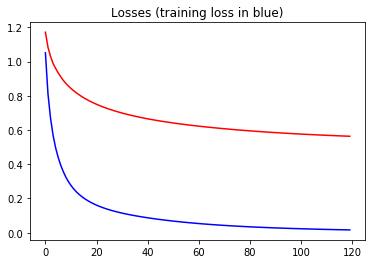

In [88]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss 

In [89]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.5634311437606812


### Visualise predicted vs. actual

In [90]:
# pick a row, generate predictions
idx = 10
X, Y = valid_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
Y_tilde = lae_model(Y)

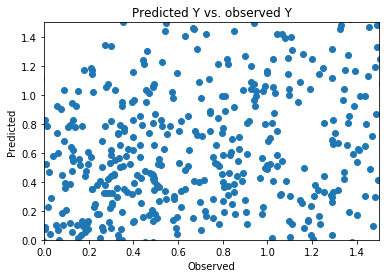

In [91]:
# Y_tilde vs. Y
plt.scatter(Y.detach().numpy(), Y_tilde.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Now use these weights in a TEA

In [ ]:
class LinearTEA(nn.Module):
    """A pytorch module to build a linear target-embedding autoencoder"""

    def __init__(self, input_dim = 194, hidden_dim = 256, output_dim = 1643):
        """
        Parameters
        ----------
        input_dim : int
            The number of input features
        hidden_dim : int
            The number of features in the hidden layer
        output_dim : int
            The number of output features
        """
        super().__init__()
        self.input_X = nn.Linear(input_dim, hidden_dim)
        self.input_Y = nn.Linear(output_dim, hidden_dim)
        self.predict_Y = nn.Linear(hidden_dim, output_dim)
  
    def forward(self, X, Y):
        Z_from_X = self.input_X(X)
        Z_from_Y = self.input_Y(Y)
        Y_hat = self.predict_Y(Z_from_Y)
        return Y_hat, Z_from_Y, Z_from_X
    
    def update_batch(self, X, Y, optimizer, criterion, train = True):
        """update_batch takes a model, data, a learning rate and a boolean indicating whether this update 
        should be treated as a training run (i.e. the model's weights should be updated) 
        or not. This function is not for production use, as it has a number of hidden parameters (e.g. optimizer).  

        Parameters
        ----------
        model : torch.nn.mnodule
            The model to be updated
        X : torch.FloatTensor
            The input data (i.e feature matrix)
        Y : torch.FloatTensor
            The target matrix)
        train : bool
            Should the weights be updated (default = True)
        """
        Y_hat, Z, Z_hat = self.forward(X, Y)
        loss = criterion(Y, Y_hat, Z, Z_hat)
        if train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        return loss.item()

In [ ]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, Y, Y_hat, Z, Z_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(Z_hat, Z)) )

In [ ]:
ltea_model = LinearTEA(input_dim, hidden_dim, output_dim)
ltea_model

### Copy the weights and biases from the trained AE

In [ ]:
ltea_model.input_Y.load_state_dict(lae_model.input.state_dict(), strict=True)

In [ ]:
ltea_model.predict_Y.load_state_dict(lae_model.output.state_dict(), strict=True)

In [ ]:
# train the linear TEA
epochs = 100
lr = 1e-3
opt = optim.Adam(ltea_model.parameters(), lr)
criterion = joint_loss(lambda_=.5) # if one, then it shouldn't learn to predict
train_loss, valid_loss = [], []

In [ ]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

In [ ]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss

In [ ]:
print("Final valid loss: {}".format(valid_loss[-1]))

### Visualise predicted vs. actual

In [ ]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
Y_hat, _, _ = ltea_model(X, Y)

In [ ]:
# Y_hat vs Y
plt.scatter(Y.detach().numpy(), Y_hat.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Test loss 

In [ ]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

In [ ]:
gc.collect()